<a href="https://colab.research.google.com/github/hexterisk/CT-GAN/blob/master/ELM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

## Mounting

In [0]:
# Mount Google Drive files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installs

In [0]:
!pip install plotly scikit-image dicom pydicom opencv-python==3.4.2.16 numpy Keras tensorflow opencv-contrib-python==3.4.2.16

## Importing

In [0]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.figure_factory import create_trisurf
from plotly.graph_objs import *
import dicom
import cv2
from PIL import Image
import pandas as pd

## ELM
import h5py
from keras.datasets import mnist
from keras.utils import to_categorical

%matplotlib inline


# Listing files

### Angel:

In [0]:
# Folder that contains the tampered 1003
#!ls "/content/drive/My Drive/Tampered Scans/Experiment 1 - Blind/1003/"
# Folder that contains the original 1003
#!ls "/content/drive/My Drive/Origional Scans/set1/cleanedD_LC2_deep2b_noE_1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053"
tampered_root_path = "/content/drive/My Drive/Tampered Scans"
original_root_path = "/content/drive/My Drive/Origional Scans"

### Bhanu:

In [0]:
# Folder that contains the tampered 1003
#!ls "/content/drive/My Drive/ICSML-2019/Tampered Scans/Experiment 1 - Blind/1003"

# Folder that contains the original 1003
#!ls "/content/drive/My Drive/ICSML-2019/Origional Scans/set1/cleanedD_LC2_deep2b_noE_1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053"

#tampered_root_path = "/content/drive/My Drive/ICSML-2019/Tampered Scans"
#original_root_path = "/content/drive/My Drive/ICSML-2019/Origional Scans"

### Tampered images

In [0]:
tampered_images = {}

for tampered_image_path in os.listdir(tampered_root_path + "/Experiment 1 - Blind"):
  tampered_image_full_path = tampered_root_path + "/Experiment 1 - Blind/" + tampered_image_path
  # print(tampered_image_path)
  if (tampered_image_path == "1003"):
    tampered_images[tampered_image_path] = [dicom.read_file(tampered_image_full_path + "/" + tampered_image_file) for tampered_image_file in os.listdir(tampered_image_full_path)]
      
print(tampered_images)

{'1003': [(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'SECONDARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.14768062998490586166
(0008, 0020) Study Date                          DA: '20000101'
(0008, 0021) Series Date                         DA: '20000101'
(0008, 0022) Acquisition Date                    DA: '20000101'
(0008, 0023) Content Date                        DA: '20000101'
(0008, 0024) Overlay Date                        DA: '20000101'
(0008, 0025) Curve Date                          DA: '20000101'
(0008, 002a) Acquisition DateTime                DT: '20000101'
(0008, 0030) Study Time                          TM: ''
(0008, 0032) Acquisition Time                    TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number             

### Original images

In [0]:
original_images = {}

for original_image_path in os.listdir(original_root_path + '/set1'):
  original_image_full_path = original_root_path + "/set1/" + original_image_path
  # print(original_image_path)
  parsed_original_image_path = original_image_path.split(".")[-1][0:4]
  if (parsed_original_image_path == "1003"):
    original_images[parsed_original_image_path] = [dicom.read_file(original_image_full_path + "/" + original_image_file) for original_image_file in  os.listdir(original_image_full_path)]

print(original_images)

{'1003': [(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'SECONDARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 0
(0008, 0020) Study Date                          DA: '20000101'
(0008, 0021) Series Date                         DA: '20000101'
(0008, 0022) Acquisition Date                    DA: '20000101'
(0008, 0023) Content Date                        DA: '20000101'
(0008, 0024) Overlay Date                        DA: '20000101'
(0008, 0025) Curve Date                          DA: '20000101'
(0008, 002a) Acquisition DateTime                DT: '20000101'
(0008, 0030) Study Time                          TM: ''
(0008, 0032) Acquisition Time                    TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number                    SH: '2819497684894126'
(0008, 0060) Modality  

# Visualising

## Fetching and saving slices

In [0]:
data_path = tampered_root_path + "/Experiment 1 - Blind/1003"
output_path = working_path = ""
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print('\n'.join(g[:5]))

Total of 481 DICOM images.
First 5 filenames:
/content/drive/My Drive/Tampered Scans/Experiment 1 - Blind/1003/1.dcm
/content/drive/My Drive/Tampered Scans/Experiment 1 - Blind/1003/10.dcm
/content/drive/My Drive/Tampered Scans/Experiment 1 - Blind/1003/101.dcm
/content/drive/My Drive/Tampered Scans/Experiment 1 - Blind/1003/0.dcm
/content/drive/My Drive/Tampered Scans/Experiment 1 - Blind/1003/102.dcm


In [0]:
# Loop over the image files and store everything into a list.

def load_scan(slices):
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices

def load_scan_from_path(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    return load_scan(slices)

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
imgs = get_pixels_hu(load_scan_from_path(data_path))

In [0]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

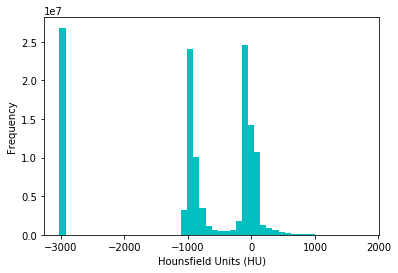

In [0]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

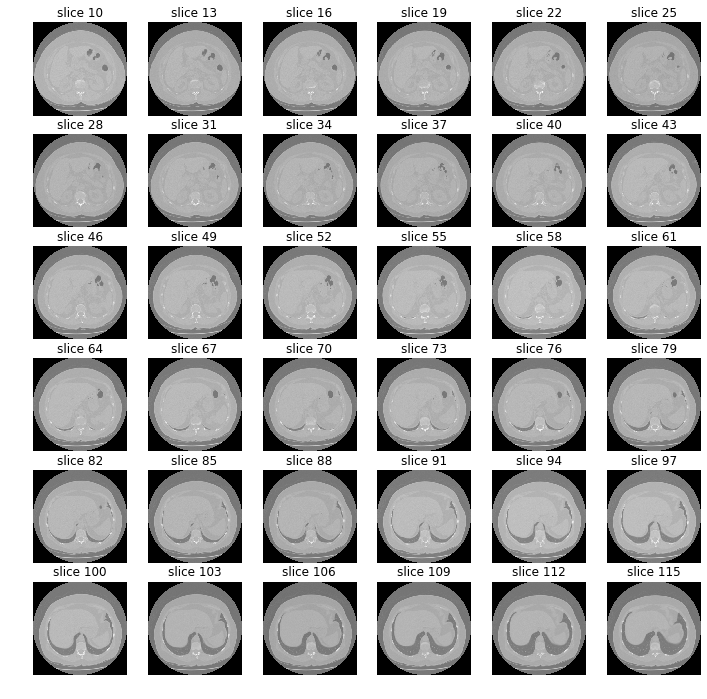

In [0]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind], cmap=plt.cm.gray)
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [0]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)

    return image, new_spacing

In [0]:
def make_mesh(image, threshold=350, step_size=2):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print ("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
    # colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

## 2D comparsion

Text(0.5, 1.0, 'Original')

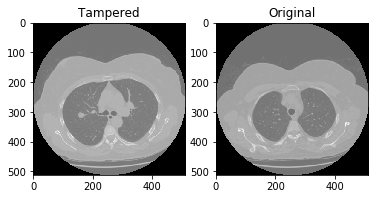

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(tampered_images["1003"][295].pixel_array, cmap=plt.cm.gray)
ax1.set_title('Tampered')
ax2.imshow(original_images["1003"][295].pixel_array, cmap=plt.cm.gray)
ax2.set_title('Original')

## 3D comparison

In [0]:
def render(scan, patient_name):
  patient = load_scan(scan[patient_name])
  images = get_pixels_hu(patient)
  print ("Shape before resampling\t", images.shape)
  images_after_resample, spacing = resample(images, patient, [1, 1, 1])
  print ("Shape after resampling\t", images_after_resample.shape)

  v, f = make_mesh(images_after_resample, 350)
  plt_3d(v, f)

Shape before resampling	 (481, 512, 512)
Shape after resampling	 (301, 360, 360)
Transposing surface
Calculating surface
Drawing


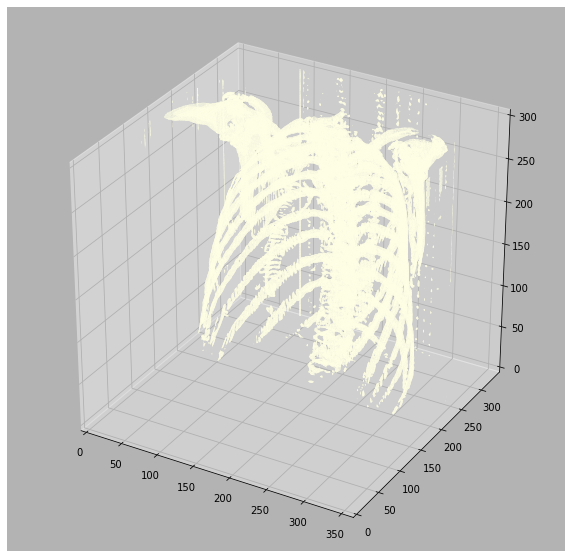

In [0]:
patient_name = "1003"
render(tampered_images, patient_name)
#render(original_images, patient_name)

## LBP Reading

In [0]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    '''

     64 | 128 |   1
    ----------------
     32 |   0 |   2
    ----------------
     16 |   8 |   4    

    '''    
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top
    
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val    

def show_output(output_list):
    output_list_len = len(output_list)
    figure = plt.figure(figsize=(15, 15))
    for i in range(output_list_len):
        current_dict = output_list[i]
        current_img = current_dict["img"]
        current_xlabel = current_dict["xlabel"]
        current_ylabel = current_dict["ylabel"]
        current_xtick = current_dict["xtick"]
        current_ytick = current_dict["ytick"]
        current_title = current_dict["title"]
        current_type = current_dict["type"]
        current_plot = figure.add_subplot(1, output_list_len, i+1)
        if current_type == "gray":
            current_plot.imshow(current_img, cmap = plt.get_cmap('gray'))
            current_plot.set_title(current_title)
            current_plot.set_xticks(current_xtick)
            current_plot.set_yticks(current_ytick)
            current_plot.set_xlabel(current_xlabel)
            current_plot.set_ylabel(current_ylabel)
        elif current_type == "histogram":
            current_plot.plot(current_img, color = "black")
            current_plot.set_xlim([0,260])
            current_plot.set_title(current_title)
            current_plot.set_xlabel(current_xlabel)
            current_plot.set_ylabel(current_ylabel)            
            ytick_list = [int(i) for i in current_plot.get_yticks()]
            current_plot.set_yticklabels(ytick_list,rotation = 90)

    plt.show()

def get_dicom_grayscale_cv2(data):
    pil_image = Image.fromarray(data.astype('uint8'), 'P')
    rgbimg = Image.new("RGB", pil_image.size)
    rgbimg.paste(pil_image)
    img = cv2.cvtColor(np.array(rgbimg).astype('uint8'), cv2.COLOR_BGR2GRAY)
    return img
  
def get_lbp_image(img_dicom):
    img_dicom_gray = get_dicom_grayscale_cv2(img_dicom)
    height, width = img_dicom_gray.shape
    
    img_lbp = np.zeros((height, width, 3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
            img_lbp[i, j] = lbp_calculated_pixel(img_dicom_gray, i, j)

    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    output_list = []
    output_list.append({
        "img": img_dicom_gray,
        "xlabel": "",
        "ylabel": "",
        "xtick": [],
        "ytick": [],
        "title": "Gray Image",
        "type": "gray"        
    })
    output_list.append({
        "img": img_lbp,
        "xlabel": "",
        "ylabel": "",
        "xtick": [],
        "ytick": [],
        "title": "LBP Image",
        "type": "gray"
    })    
    # output_list.append({
    #     "img": hist_lbp,
    #     "xlabel": "Bins",
    #     "ylabel": "Number of pixels",
    #     "xtick": None,
    #     "ytick": None,
    #     "title": "Histogram(LBP)",
    #     "type": "histogram"
    # })

    return img_lbp, output_list

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [248 248 248]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [248 248 248]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [248 248 248]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [248 248 248]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [248 248 248]]

 [[227 227 227]
  [227 227 227]
  [227 227 227]
  ...
  [227 227 227]
  [227 227 227]
  [224 224 224]]]
(512, 512, 3)


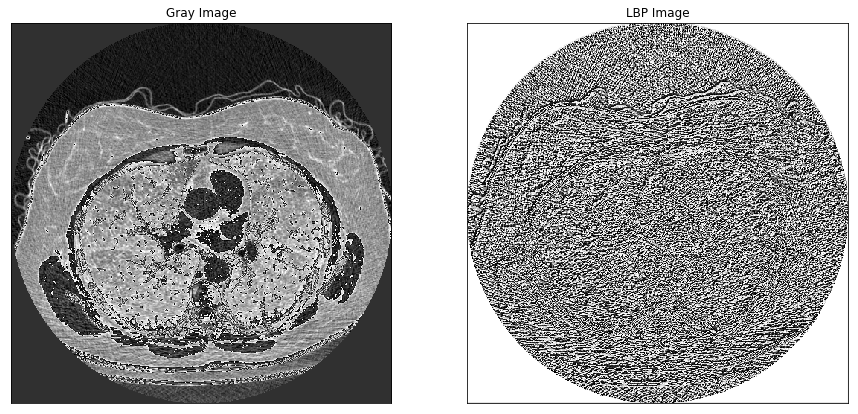

In [0]:
img_lbp, output_list = get_lbp_image(tampered_images["1003"][253].pixel_array)
#plt.imshow(img_lbp)
print(img_lbp)
print(img_lbp.shape)
show_output(output_list)

# Model

## ELM implementation

### [Library](https://github.com/otenim/Numpy-ELM/blob/master/elm.py)

In [0]:
def softmax(x):
    c = np.max(x, axis=-1)
    upper = np.exp(x - c)
    lower = np.sum(upper, axis=-1)
    return upper / lower

def _mean_squared_error(y_true, y_pred):
    return 0.5 * np.mean((y_true - y_pred)**2)

def _mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _identity(x):
    return x

class ELM(object):
    def __init__(
        self, n_input_nodes, n_hidden_nodes, n_output_nodes,
        activation='sigmoid', loss='mean_squared_error', name=None,
        beta_init=None, alpha_init=None, bias_init=None):

        self.name = name
        self.__n_input_nodes = n_input_nodes
        self.__n_hidden_nodes = n_hidden_nodes
        self.__n_output_nodes = n_output_nodes

        # initialize weights and a bias
        if isinstance(beta_init, np.ndarray):
            if beta_init.shape != (self.__n_hidden_nodes, self.__n_output_nodes):
                raise ValueError(
                    'the shape of beta_init is expected to be (%d,%d).' % (self.__n_hidden_nodes, self.__n_output_nodes)
                )
            self.__beta = beta_init
        else:
            self.__beta = np.random.uniform(-1.,1.,size=(self.__n_hidden_nodes, self.__n_output_nodes))
        if isinstance(alpha_init, np.ndarray):
            if alpha_init.shape != (self.__n_input_nodes, self.__n_hidden_nodes):
                raise ValueError(
                    'the shape of alpha_init is expected to be (%d,%d).' % (self.__n_hidden_nodes, self.__n_output_nodes)
                )
            self.__alpha = alpha_init
        else:
            self.__alpha = np.random.uniform(-1.,1.,size=(self.__n_input_nodes, self.__n_hidden_nodes))
        if isinstance(bias_init, np.ndarray):
            if bias_init.shape != (self.__n_hidden_nodes,):
                raise ValueError(
                    'the shape of bias_init is expected to be (%d,).' % (self.__n_hidden_nodes,)
                )
            self.__bias = bias_init
        else:
            self.__bias = np.zeros(shape=(self.__n_hidden_nodes,))

        # set an activation function
        self.__activation = self.__get_activation_function(activation)

        # set a loss function
        self.__loss = self.__get_loss_function(loss)

    def __call__(self, x):
        h = self.__activation(x.dot(self.__alpha) + self.__bias)
        return h.dot(self.__beta)

    def predict(self, x):
        return list(self(x))

    def evaluate(self, x, t, metrics=['loss']):
        y_pred = self.predict(x)
        y_true = t
        y_pred_argmax = np.argmax(y_pred, axis=-1)
        y_true_argmax = np.argmax(y_true, axis=-1)
        ret = []
        for m in metrics:
            if m == 'loss':
                loss = self.__loss(y_true, y_pred)
                ret.append(loss)
            elif m == 'accuracy':
                acc = np.sum(y_pred_argmax == y_true_argmax) / len(t)
                ret.append(acc)
            elif m == 'uar':
                num_classes = len(t[0])
                uar = []
                for i in range(num_classes):
                    tp = np.sum((y_pred_argmax == i) & (y_true_argmax == i))
                    tp_fn = np.sum(y_true_argmax == i)
                    uar.append(tp / tp_fn)
                uar = np.mean(uar)
                ret.append(uar)
            else:
                raise ValueError(
                    'an unknown evaluation indicator \'%s\'.' % m
                )
        if len(ret) == 1:
            ret = ret[0]
        elif len(ret) == 0:
            ret = None
        return ret


    def fit(self, x, t):
        H = self.__activation(x.dot(self.__alpha) + self.__bias)

        # compute a pseudoinverse of H
        H_pinv = np.linalg.pinv(H)

        # update beta
        self.__beta = H_pinv.dot(t)

    def save(self, filepath):
        with h5py.File(filepath, 'w') as f:
            arc = f.create_dataset('architecture', data=np.array([self.__n_input_nodes, self.__n_hidden_nodes, self.__n_output_nodes]))
            arc.attrs['activation'] = self.__get_activation_name(self.__activation).encode('utf-8')
            arc.attrs['loss'] = self.__get_loss_name(self.__loss).encode('utf-8')
            arc.attrs['name'] = self.name.encode('utf-8')
            f.create_group('weights')
            f.create_dataset('weights/alpha', data=self.__alpha)
            f.create_dataset('weights/beta', data=self.__beta)
            f.create_dataset('weights/bias', data=self.__bias)

    def __get_activation_function(self, name):
        if name == 'sigmoid':
            return _sigmoid
        elif name == 'identity':
            return _identity
        else:
            raise ValueError(
                'an unknown activation function \'%s\'.' % name
            )

    def __get_activation_name(self, activation):
        if activation == _sigmoid:
            return 'sigmoid'
        elif activation == _identity:
            return 'identity'

    def __get_loss_function(self, name):
        if name == 'mean_squared_error':
            return _mean_squared_error
        elif name == 'mean_absolute_error':
            return _mean_absolute_error
        else:
            raise ValueError(
                'an unknown loss function \'%s\'.' % name
            )

    def __get_loss_name(self, loss):
        if loss == _mean_squared_error:
            return 'mean_squared_error'
        elif loss == _mean_absolute_error:
            return 'mean_absolute_error'
    
    @property
    def weights(self):
        return {
            'alpha': self.__alpha,
            'beta': self.__beta,
            'bias': self.__bias,
        }

    @property
    def input_shape(self):
        return (self.__n_input_nodes,)

    @property
    def output_shape(self):
        return (self.__n_output_nodes,)

    @property
    def n_input_nodes(self):
        return self.__n_input_nodes

    @property
    def n_hidden_nodes(self):
        return self.__n_hidden_nodes

    @property
    def n_output_nodes(self):
        return self.__n_output_nodes

    @property
    def activation(self):
        return self.__get_activation_name(self.__activation)

    @property
    def loss(self):
        return self.__get_loss_name(self.__loss)

def load_model(filepath):
    with h5py.File(filepath, 'r') as f:
        alpha_init = f['weights/alpha'][...]
        beta_init = f['weights/beta'][...]
        bias_init = f['weights/bias'][...]
        arc = f['architecture']
        n_input_nodes = arc[0]
        n_hidden_nodes = arc[1]
        n_output_nodes = arc[2]
        activation = arc.attrs['activation'].decode('utf-8')
        loss = arc.attrs['loss'].decode('utf-8')
        name = arc.attrs['name'].decode('utf-8')
        model = ELM(
            n_input_nodes=n_input_nodes,
            n_hidden_nodes=n_hidden_nodes,
            n_output_nodes=n_output_nodes,
            activation=activation,
            loss=loss,
            alpha_init=alpha_init,
            beta_init=beta_init,
            bias_init=bias_init,
            name=name,
        )
    return model

## SIFT

In [0]:
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

In [0]:
# img = tampered_images["1003"][0].pixel_array
# img_t = original_images["1003"][0].pixel_array

# # plt.imsave('o.jpg', img, cmap='gray')
# # plt.imsave('o_t.jpg', img_t, cmap='gray')
# # img_gray = cv2.imread('o.jpg')
# # img_tgray = cv2.imread('o_t.jpg')

# img_gray = get_dicom_grayscale_cv2(img)
# img_tgray = get_dicom_grayscale_cv2(img_t)

In [0]:
# # generate SIFT keypoints and descriptors
# img_lbp, output_list = get_lbp_image(img_gray)
# img_tlbp, output_tlist = get_lbp_image(img_tgray)


# okp, odesc = gen_sift_features(img_lbp)
# o_tkp, o_tdesc = gen_sift_features(img_tlbp)


# print('Here are what our SIFT features look like for the front-view octopus image:')
# show_sift_features(img_lbp, img, okp)

In [0]:
# show_sift_features(img_tlbp, img_t, o_tkp)

In [0]:
# bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# matches = bf.match(odesc, o_tdesc)

# # Sort the matches in the order of their distance.
# matches = sorted(matches, key = lambda x:x.distance)

# # draw the top N matches
# N_MATCHES = 100

# match_img = cv2.drawMatches(
#     img_lbp, okp,
#     img_tlbp, o_tkp,
#     matches[:N_MATCHES], img_tlbp.copy(), flags=0)

# plt.figure(figsize=(12,6))
# plt.imshow(match_img);

# Trial

## Load labels dataset

In [0]:
exp1labels = np.genfromtxt(tampered_root_path + '/labels_exp1.csv', delimiter=',')
exp2labels = np.genfromtxt(tampered_root_path + '/labels_exp2.csv', delimiter=',')

In [0]:
def load_images_from_folder_tampered(root, images, labels):
  print("Root folder: ", root)
  category = []
  for i in range(1, len(labels)):
    #print(str(int(labels[i][1])), " : ", str(int(labels[i][2])))
    if((int(labels[i][3]) != 0) and (int(labels[i][4])) != 0):
      path = root + '/Experiment 1 - Blind/' + str(int(labels[i][1])) + '/' + str(int(labels[i][2])) + ".dcm"
      if(os.path.isfile(path)==True):
        img = dicom.read_file(path)
        lbp_img, _ = get_lbp_image(img.pixel_array)
        category.append(lbp_img)
      else:
        path = root + '/Experiment 2 - Open/' + str(int(labels[i][1])) + '/' + str(int(labels[i][2])) + ".dcm"
        if(os.path.isfile(path)==True):
          img = dicom.read_file(path)
          lbp_img, _ = get_lbp_image(img.pixel_array)
          category.append(lbp_img)
        else:
          print("FILE DOES NOT EXIST!")
    else:
      continue
  images['tampered'] = np.asarray(category)
  return images, np.asarray(category)

In [0]:
def load_images_from_folder_original(root, images, labels):
  print("Root folder: ", root)
  category = []
  for i in range(1, len(labels)):
    if((int(labels[i][3]) != 0) and (int(labels[i][4])) != 0):
      found = False
      #print(str(int(labels[i][1])), " : ", str(int(labels[i][2])))
      root_path = root + '/set1'
      for original_image_path in os.listdir(root_path):
        parsed_original_image_path = original_image_path.split(".")[-1][0:4]
        if(str(int(labels[i][1])) == parsed_original_image_path):
          path = root_path + '/' + original_image_path + '/' + str(int(labels[i][2])) + ".dcm"
          if(os.path.isfile(path)==True):
            found = True
            img = dicom.read_file(path)
            lbp_img, _ = get_lbp_image(img.pixel_array)
            category.append(lbp_img)
      if(found == False):
        root_path = root + '/set2'
        for original_image_path in os.listdir(root_path):
          parsed_original_image_path = original_image_path.split(".")[-1][0:4]
          if(str(int(labels[i][1])) == parsed_original_image_path):
            path = root_path + '/' + original_image_path + '/' + str(int(labels[i][2])) + ".dcm"
            if(os.path.isfile(path)==True):
              found = True
              img = dicom.read_file(path)
              lbp_img, _ = get_lbp_image(img.pixel_array)
              category.append(lbp_img)
              #np.array(img.pixel_array, dtype=np.uint8)
            else:
              print("FILE DOES NOT EXIST!")
    else:
      continue
  images['original'] = np.asarray(category)
  return images, np.asarray(category)

In [0]:
images_train = {}
#images_tamp = load_images_from_folder_tampered(tampered_root_path, images_train, exp1labels)
#images_orig, category = load_images_from_folder_original(original_root_path, images_train, exp1labels)

#images_train.update(images_orig)
#images_train.update(images_tamp)

# print(len(images_train['tampered']))
#print(len(images_train['original']))
#print(len(category))

In [0]:
# images_test = {}

# images_tamp_test = load_images_from_folder_tampered(tampered_root_path, images, exp2labels)
# images_orig_test = load_images_from_folder_original(original_root_path, images, exp2labels)

# images_test.update(images_orig_test)
# images_test.update(images_tamp_test)

# print(len(images_test['tampered']))
# print(len(images_test['original']))

## Sift Train

In [0]:
# import numpy as np
# import cv2
# import os
# from scipy import ndimage
# from scipy.spatial import distance
# from sklearn.cluster import KMeans

In [0]:
# i, output_list = get_lbp_image(images_train['tampered'][4])
# plt.imshow(i)
# #lol, k = gen_sift_features(i)
# #show_output(output_list)

In [0]:
# def gen_sift_features(gray_img):
#     sift = cv2.xfeatures2d.SIFT_create()
#     # kp is the keypoints
#     #
#     # desc is the SIFT descriptors, they're 128-dimensional vectors
#     # that we can use for our final features
#     kp, desc = sift.detectAndCompute(gray_img, None)
#     return kp, desc

# def show_sift_features(gray_img, color_img, kp):
#     return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

In [0]:
# # Creates descriptors using sift 
# # Takes one parameter that is images dictionary
# # Return an array whose first index holds the decriptor_list without an order
# # And the second index holds the sift_vectors dictionary which holds the descriptors but this is seperated class by class
# def sift_features(images):
#     sift_vectors = {}
#     descriptor_list = []
#     sift = cv2.xfeatures2d.SIFT_create()
#     for key,value in images.items():
#         #plt.imshow(value)
#         features = []
#         for img in value:
#             kp, des = sift.detectAndCompute(img,None)
           
            
#             descriptor_list.extend(des)
#             features.append(des)
#         sift_vectors[key] = features
#     return [descriptor_list, sift_vectors]

# #sifts = sift_features(images_train)
# sifts = sift_features(images_train)
# #print(sifts)
# # Takes the descriptor list which is unordered one
# descriptor_list = sifts[0] 
# # Takes the sift features that is seperated class by class for train data
# all_bovw_feature = sifts[1] 
# # Takes the sift features that is seperated class by class for test data
# test_bovw_feature = sift_features(images_test)[1] 

In [0]:
# # A k-means clustering algorithm who takes 2 parameter which is number 
# # of cluster(k) and the other is descriptors list(unordered 1d array)
# # Returns an array that holds central points.
# def kmeans(k, descriptor_list):
#     kmeans = KMeans(n_clusters = k, n_init=10)
#     kmeans.fit(descriptor_list)
#     visual_words = kmeans.cluster_centers_ 
#     return visual_words
    
# # Takes the central points which is visual words    
# visual_words = kmeans(150, descriptor_list) 

In [0]:
# def find_index(image, center):
#     count = 0
#     ind = 0
#     for i in range(len(center)):
#         if(i == 0):
#            count = distance.euclidean(image, center[i]) 
#            #count = L1_dist(image, center[i])
#         else:
#             dist = distance.euclidean(image, center[i]) 
#             #dist = L1_dist(image, center[i])
#             if(dist < count):
#                 ind = i
#                 count = dist
#     return ind

In [0]:
# # Takes 2 parameters. The first one is a dictionary that holds the descriptors that are separated class by class 
# # And the second parameter is an array that holds the central points (visual words) of the k means clustering
# # Returns a dictionary that holds the histograms for each images that are separated class by class. 
# def image_class(all_bovw, centers):
#     dict_feature = {}
#     for key,value in all_bovw.items():
#         category = []
#         for img in value:
#             histogram = np.zeros(len(centers))
#             for each_feature in img:
#                 ind = find_index(each_feature, centers)
#                 histogram[ind] += 1
#             category.append(histogram)
#         dict_feature[key] = category
#     return dict_feature
    
# # Creates histograms for train data    
# bovw_train = image_class(all_bovw_feature, visual_words) 
# # Creates histograms for test data
# bovw_test = image_class(test_bovw_feature, visual_words) 

In [0]:
# # 1-NN algorithm. We use this for predict the class of test images.
# # Takes 2 parameters. images is the feature vectors of train images and tests is the feature vectors of test images
# # Returns an array that holds number of test images, number of correctly predicted images and records of class based images respectively
# def knn(images, tests):
#     num_test = 0
#     correct_predict = 0
#     class_based = {}
    
#     for test_key, test_val in tests.items():
#         class_based[test_key] = [0, 0] # [correct, all]
#         for tst in test_val:
#             predict_start = 0
#             #print(test_key)
#             minimum = 0
#             key = "a" #predicted
#             for train_key, train_val in images.items():
#                 for train in train_val:
#                     if(predict_start == 0):
#                         minimum = distance.euclidean(tst, train)
#                         #minimum = L1_dist(tst,train)
#                         key = train_key
#                         predict_start += 1
#                     else:
#                         dist = distance.euclidean(tst, train)
#                         #dist = L1_dist(tst,train)
#                         if(dist < minimum):
#                             minimum = dist
#                             key = train_key
            
#             if(test_key == key):
#                 correct_predict += 1
#                 class_based[test_key][0] += 1
#             num_test += 1
#             class_based[test_key][1] += 1
#             #print(minimum)
#     return [num_test, correct_predict, class_based]
    
# # Call the knn function    
# results_bowl = knn(bovw_train, bovw_test) 

In [0]:
# # Calculates the average accuracy and class based accuracies.  
# def accuracy(results):
#     avg_accuracy = (results[1] / results[0]) * 100
#     print("Average accuracy: %" + str(avg_accuracy))
#     print("\nClass based accuracies: \n")
#     for key,value in results[2].items():
#         acc = (value[0] / value[1]) * 100
#         print(key + " : %" + str(acc))
        
# # Calculates the accuracies and write the results to the console.       
# accuracy(results_bowl)

## ELM Train

In [0]:
def dicom_load_data():
  _, original_images_train = load_images_from_folder_original(original_root_path, {}, exp1labels) 
  _, tampered_images_train = load_images_from_folder_tampered(tampered_root_path, {}, exp1labels) 
  x_train = np.concatenate((original_images_train, tampered_images_train))
  t_train = np.flip(np.concatenate(([[0]] * len(original_images_train), [[1]] * len(tampered_images_train))))
  
  _, original_images_test = load_images_from_folder_original(original_root_path, {}, exp2labels)
  _, tampered_images_test = load_images_from_folder_tampered(tampered_root_path, {}, exp2labels) 

  x_test = np.concatenate((original_images_test, tampered_images_test))
  t_test = np.flip(np.concatenate(([[0]] * len(original_images_test), [[1]] * len(tampered_images_test))))

  return (x_train, t_train), (x_test, t_test) 

In [0]:
# ===============================
# Load dataset
# ===============================
from keras.datasets import mnist
n_classes = 10
## To change with our data https://keras.io/datasets/
(x_train_1, t_train_1), (x_test_1, t_test_1) = mnist.load_data()
print(x_train_1.shape)
print(t_train_1.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)


In [0]:
# ===============================
# Load dataset
# ===============================
n_classes = 2
## To change with our data https://keras.io/datasets/
(x_train, t_train), (x_test, t_test) = dicom_load_data()

Root folder:  /content/drive/My Drive/Origional Scans
Root folder:  /content/drive/My Drive/Tampered Scans
Root folder:  /content/drive/My Drive/Origional Scans
Root folder:  /content/drive/My Drive/Tampered Scans


In [0]:
print(x_train.shape)
print(t_train.shape)

(239, 512, 512, 3)
(239, 1)


In [0]:
# ===============================
# Preprocess
# ===============================
x_train_2 = x_train.astype(np.float32) / 255.
x_train_2 = x_train_2.reshape(-1, 512 * 512 * 3)
x_test_2 = x_test.astype(np.float32) / 255.
x_test_2 = x_test_2.reshape(-1, 512 * 512 * 3)
t_train_2 = to_categorical(t_train, n_classes).astype(np.float32)
t_test_2 = to_categorical(t_test, n_classes).astype(np.float32)

# ===============================
# Instantiate ELM
# ===============================
model = ELM(
    n_input_nodes=512 * 512 * 3,
    n_hidden_nodes=1024,
    n_output_nodes=n_classes,
    loss='mean_squared_error',
    activation='identity',
    name='elm',
)

# ===============================
# Training
# ===============================
model.fit(x_train_2, t_train_2)
train_loss, train_acc = model.evaluate(x_train_2, t_train_2, metrics=['loss', 'accuracy'])
print('train_loss: %f' % train_loss)
print('train_acc: %f' % train_acc)

# ===============================
# Validation
# ===============================
val_loss, val_acc = model.evaluate(x_test_2, t_test_2, metrics=['loss', 'accuracy'])
print('val_loss: %f' % val_loss)
print('val_acc: %f' % val_acc)

# ===============================
# Prediction
# ========-=======================
x = x_test_2[:10]
t = t_test_2[:10]
y = softmax(model.predict(x))

for i in range(len(y)):
    print('---------- prediction %d ----------' % (i+1))
    class_pred = np.argmax(y[i])
    prob_pred = y[i][class_pred]
    class_true = np.argmax(t[i])
    print('prediction:')
    print('\tclass: %d, probability: %f' % (class_pred, prob_pred))
    print('\tclass (true): %d' % class_true)

# ===============================
# Save model
# ===============================
print('saving model...')
model.save('model.h5')
del model

# ===============================
# Load model
# ===============================
print('loading model...')
model = load_model('model.h5')

train_loss: 0.020921
train_acc: 0.916318
val_loss: 8.139456
val_acc: 0.500000


ValueError: ignored